In [2]:
import os
from pathlib import Path
import requests
import tarfile
from tqdm import tqdm
import json
import numpy as np
import shutil
import pandas as pd
import librosa
import librosa.display
import sounddevice as sd
sd.default.samplerate = 16000
import torch
from torch.utils import data
import torchaudio as ta
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import scipy.fft as spfft
librosa.set_fftlib(spfft)

pd.set_option('display.max_columns', 30)

# This assumes you already have the dataset downloaded, and only splits the actual files so they can be loaded conditionally

In [3]:
def create_dataset_df(json_file, instrument_family_str="all", instrument_source_str="all", pitch=[0, 127], velocity=[0, 127], include_qualities=[], exclude_qualities=["distortion"]):
    
    if isinstance(json_file, (str, Path)):
        path = Path(json_file)
        assert path.is_file(), "json_file needs to point to an examples.json file."
        with open(path) as f:
            df = pd.DataFrame.from_records(json.load(f)).T
    else:
        assert isinstance(json_file, pd.DataFrame), "json_file needs to be a pandas DataFrame or a string containing a path to the examples.json file"
        df = json_file
        
    print("JSON loaded into DataFrame!")
    
    try:
        if instrument_family_str != "all":
            df = df[df["instrument_family_str"] == instrument_family_str]
        if instrument_source_str != "all":
            df = df[df["instrument_source_str"] == instrument_source_str]
        
        if pitch != [0, 127]:
            df = df[(df["pitch"] >= pitch[0]) & (df["pitch"] <= pitch[1])]
        if velocity != [0, 127]:
            df = df[(df["velocity"] >= velocity[0]) & (df["velocity"] <= velocity[1])]
        
        # Map quality strings to 1/0 lists and filter based on those
        qualities_str = ["bright", "dark", "distortion", "fast_decay", "long_release", "multiphonic", "nonlinear_env", "percussive", "reverb", "tempo-synced"]
        assert all([x in qualities_str for x in (include_qualities + exclude_qualities)]), "Some referred qualities are not legal quality strings."
        
        if len(include_qualities) != 0:
            qualities = [1 if x in include_qualities else 0 for x in qualities_str]
            # sum(a and b) == sum(a) - all those in included need to be in there
            df = df[df.qualities.apply(lambda x: sum(qualities) == sum(np.logical_and(x, qualities)))]
        if len(exclude_qualities) > 0:
            qualities = [1 if x in exclude_qualities else 0 for x in qualities_str]
            # not any(df_qualities and qualities) - there can't be any of the excluded ones in there
            df = df[df.qualities.apply(lambda x: not any(np.logical_and(x, qualities)))]
    except AttributeError as a:
        print("Most likely the selection you want doesn't exist. Try broadening the options or find the bug!")
        raise a
    except Exception as e:
        raise e
    
    return df


def dftostr(df: pd.DataFrame):
    return df["note_str"].apply(lambda x: x + ".wav").to_list()


n_samples_nsynth = 64000
sample_rate_nsynth = 16000
def load_files(path, files: list, format="pytorch"):
    assert format in ["pytorch", "numpy"], "Format {} not yet supported.".format(format)
    
    data = np.empty((n_samples_nsynth, len(files)), dtype=np.float32, order="F")
    for i, f in enumerate(files):
        data[:, i], _ = librosa.load(path / f, sr=sample_rate_nsynth)
        
    if format == "numpy":
        return data
    if format == "pytorch":
        warning("If you want to train PyTorch models, you should use the NSynth dataset class.")
        return torch.as_tensor(data)

In [4]:
class NSynth(data.Dataset):
    """PyTorch Dataset for the NSynth dataset."""
    
    def __init__(self, root, json_df: pd.DataFrame, target_field: str, transform=None):
        if isinstance(root, (str, Path)):
            root = Path(root)
            assert root.parts[-1] == "audio", "root needs to point to the nsynth-***/audio folder."
        assert target_field in ["instrument", "instrument_source", "instrument_family", "instrument_class"]
        
        self.root = root
        self.filenames = dftostr(json_df)

        if target_field == "instrument_class":
            # Encode source and family together to make 33 distinct classes
            json_df["instrument_class"] = json_df.apply(lambda x: x["instrument_source"]*11 + x["instrument_family"], axis=1)
        self.json_df = json_df
        
        self.targets = json_df[target_field].to_list()
        self.transform = transform
        

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, index):
        path = self.root / self.filenames[index]
        x, _ = ta.load(path, normalization=False)
        if self.transform is not None:
            x = self.transform(x)
        return x, self.targets[index]
    
SPLIT_SEED = 42
def get_train_test(df: pd.DataFrame, target_field, test_size=0.2):
    if target_field == "instrument_class":
        # Encode source and family together to make 33 distinct classes
        df["instrument_class"] = df.apply(lambda x: x["instrument_source"] * 11 + x["instrument_family"], axis=1)
    targets = df[target_field]
    trdf, tedf = train_test_split(df, test_size=test_size, stratify=df[target_field], random_state=SPLIT_SEED)
    return trdf, tedf

In [5]:
#transform = lambda y: torch.as_tensor(np.abs(librosa.cqt(y.numpy().ravel(), sr=16000, hop_length=192))[np.newaxis, :])
#transform = ta.transforms.MelSpectrogram(n_fft=800, hop_length=160)
transform = None

In [6]:
path = Path("/home/tim/Desktop/MLP64/dataset/nsynth-valid/")
vdf = create_dataset_df(path / "examples.json")
trdf, tedf = get_train_test(vdf, "instrument_family")
trds = NSynth(path / "audio", trdf, target_field="instrument_family", transform=transform)
teds = NSynth(path / "audio", tedf, target_field="instrument_family", transform=transform)
trloader = data.DataLoader(trds, batch_size=32)
teloader = data.DataLoader(teds, batch_size=32)

#path = Path("/home/tim/Desktop/MLP64/dataset/nsynth-train/")
#tdf = filter_notes(path / "examples.json")
#ds = NSynth(path / "audio", vdf, target_field="instrument_class", transform=ta.transforms.MelSpectrogram())
#loader = data.DataLoader(ds, batch_size=32)

JSON loaded into DataFrame!


In [7]:
# Example usage to load files into numpy arrays
npdata = load_files(path / "audio", dftostr(vdf), format="numpy")

In [8]:
sd.play(npdata[:, 10])

In [15]:
# 16000 * 4 = 64000 samples
# 16000 samples per second
# 50ms are in 16000/20 = 800 samples
sr = 16000
frame_size = 0.02
frame_stride = 0.01
frame_length, frame_step = frame_size * sr, frame_stride * sr
frame_length = int(round(frame_length))
frame_step = int(round(frame_step))
signal_length = 64000
num_frames = int(np.ceil(float(np.abs(signal_length - frame_length)) / frame_step))  # Make sure that we have at least 1 frame
print(frame_length, frame_step)

320 160


In [2]:
16000/50

320.0

In [ ]:
n_fft = frame_length
hop_length = frame_step
n_mels = 128
sr = 16000
S = librosa.feature.melspectrogram(npdata[:, 9323], sr=sr, n_fft=n_fft, 
                                   hop_length=hop_length, 
                                   n_mels=n_mels)
S_DB = librosa.power_to_db(S, ref=np.max)
librosa.display.specshow(S_DB, sr=sr, hop_length=hop_length, 
                         x_axis='time', y_axis='mel');
plt.colorbar(format='%+2.0f dB');

In [ ]:
S_DB.shape

In [ ]:
print(frame_length, frame_step)

In [ ]:
num_frames

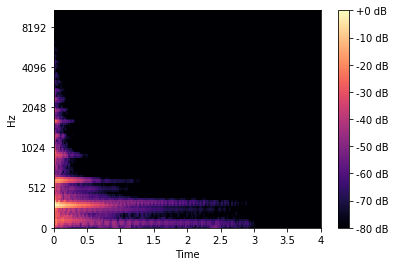

In [71]:
n_fft = frame_length
hop_length = frame_step
n_mels = 128
sr = 16000
S = librosa.feature.melspectrogram(npdata[:, 9323], sr=sr, n_fft=n_fft, 
                                   hop_length=hop_length, 
                                   n_mels=n_mels)
S_DB = librosa.power_to_db(S, ref=np.max)
librosa.display.specshow(S_DB, sr=sr, hop_length=hop_length, 
                         x_axis='time', y_axis='mel');
plt.colorbar(format='%+2.0f dB');

In [55]:
S_DB.shape

(128, 401)

In [72]:
print(frame_length, frame_step)

800 160


In [27]:
import data2

In [28]:
d = data2.EncodedFilesDataset("../dataset/nsynth-test/audio", 64000, file_type="wav")

In [15]:
d.dump_to_folder("datatest")

100%|██████████| 4096/4096 [03:33<00:00, 19.17it/s]


In [37]:
d2 = data2.H5Dataset("datatest", 64000, "wav", epoch_len=4096)
dl = torch.utils.data.dataloader.DataLoader(d2)

2020-02-20 19:15:16,920 - INFO - Dataset created. 4096 files, augmentation: False. Path: datatest


In [66]:
%%timeit 
d2.__getitem__(1)

3.37 ms ± 119 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [22]:
transform1 = lambda y: torch.as_tensor(np.abs(librosa.cqt(y.numpy().ravel(), sr=16000, hop_length=192))[np.newaxis, :])
transform2 = ta.transforms.MelSpectrogram(n_fft=800, hop_length=160)

In [87]:
path = Path("/home/tim/Desktop/MLP64/dataset/nsynth-valid/")
vdf = create_dataset_df(path / "examples.json")
trdf, tedf = get_train_test(vdf, "instrument_family")
trds = NSynth(path / "audio", trdf, target_field="instrument_family", transform=None)
teds = NSynth(path / "audio", tedf, target_field="instrument_family", transform=transform)
trloader = data.DataLoader(trds, batch_size=32)
teloader = data.DataLoader(teds, batch_size=32)

#path = Path("/home/tim/Desktop/MLP64/dataset/nsynth-train/")
#tdf = filter_notes(path / "examples.json")
#ds = NSynth(path / "audio", vdf, target_field="instrument_class", transform=ta.transforms.MelSpectrogram())
#loader = data.DataLoader(ds, batch_size=32)

JSON loaded into DataFrame!


In [82]:
%%timeit
# transform2
i = np.random.choice(4096)
trds.__getitem__(i)

1.02 ms ± 9.68 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [88]:
%%timeit
# No transform
i = np.random.choice(4096)
trds.__getitem__(i)

350 µs ± 5.16 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [76]:
%%timeit
# transform = lambda y: torch.as_tensor(np.abs(librosa.cqt(y.numpy().ravel(), sr=16000, hop_length=192))[np.newaxis, :])
i = np.random.choice(4096)
trds.__getitem__(i)

35.3 ms ± 229 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [98]:
item = trds.__getitem__(100)[0]
npitem = item.numpy().ravel() # this takes no time

In [93]:
item.shape

torch.Size([1, 64000])

In [94]:
%%timeit
transform2(item)

597 µs ± 14.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [100]:
%%timeit
# using numpy fft
librosa.cqt(npitem, sr=16000, hop_length=192)

34.3 ms ± 268 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [102]:
%%timeit
# using scipy fft
librosa.cqt(npitem, sr=16000, hop_length=192)

35 ms ± 507 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Time librosa vs torch vs numpy load

In [6]:
files = trds.filenames

In [12]:
os.getcwd()

'/home/tim/Desktop/MLP64/notebooks'

In [9]:
def load_librosa(file):
    return librosa.load(file, sr=16000)

In [13]:
%%timeit
# transform2
i = np.random.choice(4096)
a = load_librosa("../dataset/nsynth-valid/audio/" + files[i])

344 µs ± 82.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [17]:
%%timeit
# transform = lambda y: torch.as_tensor(np.abs(librosa.cqt(y.numpy().ravel(), sr=16000, hop_length=192))[np.newaxis, :])
i = np.random.choice(4096)
trds.__getitem__(i)

368 µs ± 13.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [19]:
%%timeit
# Example usage to load files into numpy arrays
npdata = load_files(path / "audio", files, format="numpy")

1.7 s ± 9.58 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [53]:
import pickle

In [60]:
'something_usersf.wav'.split('.')[0]

'something_usersf'

In [58]:
transform1(npdata[:, 0])

array([[1.6493243e-01, 1.6377628e-01, 1.6090757e-01, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [1.7682044e-01, 1.7543192e-01, 1.7201942e-01, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [1.8145946e-01, 1.7981760e-01, 1.7576969e-01, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       ...,
       [1.7689794e-06, 5.2613708e-05, 1.6083974e-04, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [1.4114272e-06, 1.2804197e-04, 4.1278246e-05, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [7.8167926e-07, 7.4845128e-05, 5.3036179e-05, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00]], dtype=float32)

In [59]:
with open('test.pkl', 'wb') as f:
    pickle.dump(transform1(npdata[:, 0]), f)

In [51]:
a.shape

(7980, 84, 334)

In [50]:
a = np.apply_along_axis(transform1, 1, npdata.T)

In [52]:
npdata.shape

(64000, 7980)

In [37]:
transform1 = lambda y:np.abs(librosa.cqt(y, sr=16000, hop_length=192))

In [24]:
npdata

array([[ 0.0000000e+00, -1.2207031e-04,  0.0000000e+00, ...,
        -1.3122559e-03, -1.6784668e-03, -3.0517578e-05],
       [ 0.0000000e+00, -1.7089844e-03,  0.0000000e+00, ...,
        -1.2237549e-02,  1.1596680e-02,  3.0517578e-05],
       [ 0.0000000e+00, -3.6621094e-03,  0.0000000e+00, ...,
        -2.9174805e-02, -1.0772705e-02, -3.0517578e-05],
       ...,
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00]], dtype=float32)